In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import scipy.io
import pandas as pd
import numpy as np
import os

input_folder = '/content/drive/MyDrive/abhi'
output_folder = '/content/drive/MyDrive/abhi_newcsv'

os.makedirs(output_folder, exist_ok=True)

for file_name in os.listdir(input_folder):

    if file_name.endswith('.mat'):
        mat = scipy.io.loadmat(os.path.join(input_folder, file_name))
        data = np.concatenate((mat['emg'], mat['stimulus']), axis=1)
        df = pd.DataFrame(data)
        output_file_name = os.path.splitext(file_name)[0] + '.csv'
        df.to_csv(os.path.join(output_folder, output_file_name), index=False)

print("Conversion completed!")


Conversion completed!


In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 48.4 MB/s eta 0:00:00


In [ ]:
import os
import pywt
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from scipy.signal import butter, filtfilt
from skimage.restoration import denoise_wavelet
from scipy.signal import find_peaks, welch
from sklearn.decomposition import PCA
from scipy.ndimage import zoom
from scipy.signal import wiener
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from scipy.signal import  iirnotch, wiener

## Formatting


In [ ]:
import re
import pandas as pd
def extract_variable_name(text):
    match = re.search(r'EMG-(.*?)(?= RT)', text)
    if match:
        return match.group(1)
    return None
desired_columns = ['time', 'BRACHIORAD.', 'EXT.CARP.ULN.', 'EXT.DIG.', 'FLEX.CAPR.U', 'FLEX.CARP.R']

In [ ]:
directory='/content/drive/MyDrive/emgdata/new_dataset/Rohit_data'
for dirs in os.listdir(directory):
    label = dirs
    lak = os.path.join(directory, dirs)
    print(dirs)
    for lak1 in os.listdir(lak):
        lak2 = os.path.join(lak, lak1)
        print(lak2)
        dataframes = []
        for filename in os.listdir(lak2):
          if not filename.startswith("concat"):
           lak3=os.path.join(lak2,filename)
           print(filename)
           df=pd.read_csv(lak3,skiprows=3)
           #print(df.head())
           varnam=extract_variable_name(filename)
           df = df.rename(columns={'value': varnam})
           dataframes.append(df.set_index('time'))
        merged_df = pd.concat(dataframes, axis=1, join='outer').reset_index()
        merged_df=merged_df[desired_columns]
        print('merged0',merged_df)
        merged_df.to_csv(os.path.join(lak2,f'concatenated_data_csv_{dirs}_{lak1}.csv'), index=False)

## Preprocessesing

In [ ]:
def denoise(df):
    cutoff_freq = 50
    order = 4
    time = df['time'].iloc[-1]
    fs = len(df.time)/time
    b, a = butter(order, cutoff_freq / (fs / 2), btype='high')
    for i in range(1,df.shape[1]):
        signal = np.array(df.iloc[:,i]).astype(np.float64)
        filtered_signal = filtfilt(b, a, signal)
        x_denoise = denoise_wavelet(filtered_signal, method='BayesShrink', mode='soft', wavelet_levels=3,
                                    wavelet='sym8', rescale_sigma='True')
        df.iloc[:,i] = wiener(x_denoise)
    return None

In [ ]:
def denoise_new_one(df):
    low_cutoff = 5
    high_cutoff = 500
    order = 4
    notch_freq = 50
    quality_factor = 30
    time_duration = df['time'].iloc[-1] - df['time'].iloc[0]  # total time duration
    fs = len(df['time']) / time_duration  # samples per second (Hz)

    if fs <= 2 * high_cutoff:
        raise ValueError("Sampling frequency must be greater than twice the highest cutoff frequency.")
    low = low_cutoff / (fs / 2)
    high = high_cutoff / (fs / 2)
    notch = notch_freq / (fs / 2)
    b_band, a_band = butter(order, [low, high], btype='band')
    b_notch, a_notch = iirnotch(notch, quality_factor)
    df_denoised = df.copy()

    for i in range(1, df.shape[1]):
        signal = np.array(df.iloc[:, i]).astype(np.float64)
        filtered_signal = filtfilt(b_band, a_band, signal)
        filtered_signal = filtfilt(b_notch, a_notch, filtered_signal)
        x_denoise = denoise_wavelet(filtered_signal, method='BayesShrink', mode='soft', wavelet_levels=3,
                                    wavelet='sym8', rescale_sigma=True)
        df_denoised.iloc[:, i] = wiener(x_denoise)

    return df_denoised

In [ ]:
def plot_signals(df, df_denoised):
    time = df['time']
    num_channels = df.shape[1] - 1
    raw_color = 'red'
    denoised_color = 'blue'

    plt.figure(figsize=(15, num_channels * 3))
    for i in range(1, df.shape[1]):
        plt.subplot(num_channels, 1, i)
        plt.plot(time, df_denoised.iloc[:, i], color=denoised_color, label=f'Denoised Channel {i}')
        plt.plot(time, df.iloc[:, i], color=raw_color, alpha=0.6, label=f'Raw Channel {i}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.title(f'Channel {i} - Raw vs. Denoised')
    plt.tight_layout()
    plt.show()
df=pd.read_csv('/content/drive/MyDrive/emgdata/new_dataset/Rohan/Fist/1/concatenated_data1.csv')
df_denoised = denoise(df)
plot_signals(df, df_denoised)


## Spectrogram Conversion Example

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from PIL import Image

def generate_spectrogram_images(df_denoised, save_dir, gesture_name='Open_Hand',lak1='kl',lak2='lak'):
    # Parameters for STFT
    window_length = 128
    overlap = 120
    dft_length = 256
    hamming_window = np.hamming(window_length)  # periodic Hamming window

    num_channels = df_denoised.shape[1] - 1
    time = df_denoised['time']

    # Loop through each channel and create the spectrogram separately
    for i in range(1, df_denoised.shape[1]):
        signal = df_denoised.iloc[:, i]

        # Compute the spectrogram
        frequencies, times, Sxx = spectrogram(
            signal,
            fs=len(time) / time.iloc[-1],  # Sampling frequency
            window=hamming_window,
            noverlap=overlap,
            nfft=dft_length,
            scaling='spectrum'
        )

        # Plot the spectrogram
        plt.figure(figsize=(6, 5))
        plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap='jet')

        # Remove the title, x-label, y-label, and colorbar
        plt.xticks([])  # Remove x-axis ticks
        plt.yticks([])  # Remove y-axis ticks
        plt.colorbar().remove()  # Remove colorbar

        # Save the spectrogram image for the channel
        filename = f"{gesture_name}_channel_{i}_{lak1}_{lak2}_spectrogram_resized.png"

        # Save the figure to a BytesIO object to avoid saving unresized image
        from io import BytesIO
        buffer = BytesIO()
        plt.savefig(buffer, format="png", bbox_inches='tight', pad_inches=0)
        buffer.seek(0)

        # Open the saved image in memory using Pillow
        img = Image.open(buffer)

        # Resize the image to 256x256 using LANCZOS resampling
        img_resized = img.resize((256, 256), Image.Resampling.LANCZOS)

        # Save the resized spectrogram image
        img_resized.save(os.path.join(save_dir, filename))
        plt.close()

def apply_window(data, window_size, samples_per_window):
    segments = []
    for i in range(0, len(data) - samples_per_window + 1, samples_per_window):
        window_data = data[i:i + samples_per_window]
        segments.append(window_data)
    return segments

directory = r'/content/drive/MyDrive/emgdata/new_dataset'
processed_data = []
data_dicts = []
aa = []

for subdir in os.listdir(directory):
    subdir_path = os.path.join(directory, subdir)
    if os.path.isdir(subdir_path):
        for dirs in os.listdir(subdir_path):
            label = dirs
            lak = os.path.join(subdir_path, dirs)
            print(f"Processing label: {label}")
            label_save_dir = os.path.join('/content/drive/MyDrive/emgdata/Data_single_images', label)
            if not os.path.exists(label_save_dir):
                os.makedirs(label_save_dir)
            for lak1 in os.listdir(lak):
                lak2 = os.path.join(lak, lak1)
                #print('lak2',lak2)
                for filename in os.listdir(lak2):
                    if filename.startswith('reconcat') and filename.endswith('.csv') and  subdir=='abhi':
                        print(lak1,subdir,label)
                        filepath = os.path.join(lak2, filename)
                        df = pd.read_csv(filepath)
                        df['time'] = df['time'] - df['time'][0]
                        df_denoised = denoise_new_one(df)
                        generate_spectrogram_images(df_denoised, label_save_dir, gesture_name=label,lak1=lak1,lak2=subdir)


Processing label: Pointing
Processing label: double
Processing label: Flexion
Processing label: Wave out
Processing label: Fist
Processing label: Ok symbol
Processing label: Wave in
Processing label: Fist
Processing label: Pointing
Processing label: double
Processing label: Wave in
Processing label: Ok symbol
Processing label: Flexion
Processing label: Wave out
Processing label: Flexion
Processing label: Fist
Processing label: double
Processing label: Wave out
Processing label: Ok symbol
Processing label: Wave in
Processing label: Pointing
Processing label: Ok symbol
Processing label: double
Processing label: Fist
Processing label: Pointing
Processing label: Wave out
Processing label: Flexion
Processing label: Wave in
Processing label: .ipynb_checkpoints
Processing label: Fist
Processing label: Ok symbol
Processing label: Pointing
Processing label: Wave out
Processing label: Flexion
Processing label: double
Processing label: Wave in
Processing label: Pointing
7 abhi Pointing
9 abhi Poi

## Deep Learning Model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 117MB/s]


New best model saved with validation accuracy: 37.25%
Epoch [1/20], Train Loss: 1.6435, Train Acc: 34.60%, Val Loss: 2.1082, Val Acc: 37.25%
Epoch [2/20], Train Loss: 0.9697, Train Acc: 65.40%, Val Loss: 3.0547, Val Acc: 27.45%
New best model saved with validation accuracy: 43.14%
Epoch [3/20], Train Loss: 0.5413, Train Acc: 80.59%, Val Loss: 3.5943, Val Acc: 43.14%
Epoch [4/20], Train Loss: 0.3656, Train Acc: 89.03%, Val Loss: 4.8133, Val Acc: 33.33%
New best model saved with validation accuracy: 47.06%
Epoch [5/20], Train Loss: 0.1713, Train Acc: 97.05%, Val Loss: 2.1461, Val Acc: 47.06%
New best model saved with validation accuracy: 50.98%
Epoch [6/20], Train Loss: 0.0795, Train Acc: 99.58%, Val Loss: 2.6059, Val Acc: 50.98%
New best model saved with validation accuracy: 64.71%
Epoch [7/20], Train Loss: 0.0570, Train Acc: 99.58%, Val Loss: 1.2832, Val Acc: 64.71%
Epoch [8/20], Train Loss: 0.0375, Train Acc: 100.00%, Val Loss: 3.8097, Val Acc: 37.25%
Epoch [9/20], Train Loss: 0.0195,

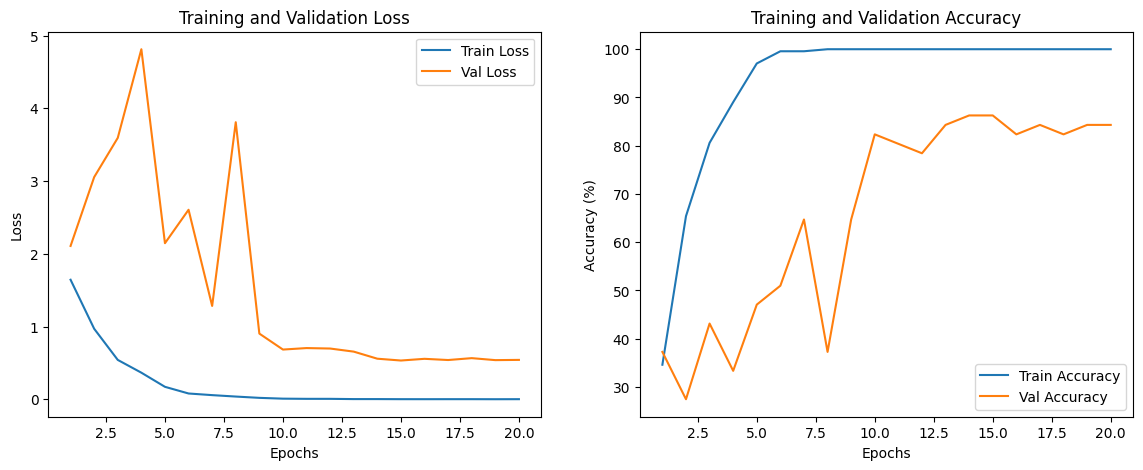

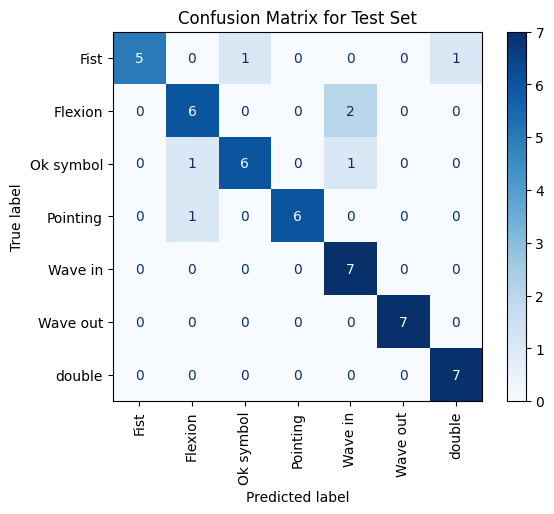

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

# Define transformation
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load full dataset
data_dir = '/content/drive/MyDrive/emgdata/Data'
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

# Split dataset into train, validation, and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

train_indices, val_test_indices = train_test_split(range(len(dataset)), test_size=(val_ratio + test_ratio), stratify=[y for _, y in dataset.samples])
val_indices, test_indices = train_test_split(val_test_indices, test_size=test_ratio / (test_ratio + val_ratio), stratify=[dataset.samples[i][1] for i in val_test_indices])

train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, val_indices)
test_set = Subset(dataset, test_indices)

# Data loaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# Self-Attention layer
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)
        attention = torch.softmax(energy, dim=-1)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)

        out = self.gamma * out + x
        return out

# Model with Self-Attention
class NETWithAttentionAndClassifier(nn.Module):
    def __init__(self, pretrained_model, num_classes, channel):
        super(NETWithAttentionAndClassifier, self).__init__()
        self.resnet = nn.Sequential(*list(pretrained_model.children())[:-2])
        self.attention = SelfAttention(channel)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channel, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        x = self.attention(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NETWithAttentionAndClassifier(torchvision.models.resnet18(pretrained=True), num_classes=len(dataset.classes), channel=512)
model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_acc = 0.0
best_model_path = '/content/drive/MyDrive/emgdata/best_model_with_attention_stacked_newone.pth'

num_epochs = 20
train_loss, val_loss = [], []
train_acc, val_acc = [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct = 0.0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_loss.append(running_loss / len(train_loader))
    train_acc.append(100 * correct / len(train_set))

    # Validation phase
    model.eval()
    running_loss, correct = 0.0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

    val_loss.append(running_loss / len(val_loader))
    val_acc.append(100 * correct / len(val_set))

    # Save model if validation accuracy improves
    if val_acc[-1] > best_val_acc:
        best_val_acc = val_acc[-1]
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with validation accuracy: {best_val_acc:.2f}%")

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}%, Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.2f}%")

# Plot loss and accuracy curves
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_acc, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Confusion matrix for test set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix for Test Set")
plt.show()
